In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [100]:
import math
from functools import reduce

In [3]:
# label_name = "resnet_18"

# model_flops_dict = {
#     "original": 2307720 * 2 * 3,
#     "resnet_18": 13412720 * 2 * 3,
#     "resnet_34": 23747720 * 2 * 3,
#     "resnet_50": 25437720 * 2 * 3
# }

# lt_real_value_dict = {
#     "original": 13.57,
#     "resnet_18": 26.76,
#     "resnet_34": 42.67,
#     "resnet_50": 45.167
# }

# model_flops = model_flops_dict[label_name]

# data_kargs = {}
# data_kargs["data"] = {}
# data_kargs["label"] = {}
# data_kargs["data_size"] = 24754
# data_kargs["batch_size"] = 64
# data_kargs["data"]["shape"] = [28, 28]
# data_kargs["data"]["type_bits"] = 32
# data_kargs["label"]["shape"] = [1]
# data_kargs["label"]["type_bits"] = 64

# fb_kargs = {}
# fb_kargs["mbps"] = 186.615
# fb_kargs["constant"] = 0.0138

# cmp_kargs = {}
# cmp_kargs["gflops"] = 94.86
# cmp_kargs["constant"] = 0.016

# lt_real_value = lt_real_value_dict[label_name]

In [4]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import sys

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pkbar
import pdb

In [5]:
from thop import profile

In [26]:
"""
data_kargs:
    * data.shape: List
    * nr_bits for the type of data: int
    * label.shape: List
    * nr_bits for the type of label: int
fb_kargs:
    * bandwidth (Mbps): float
    * constant: float
cmp_kargs:
    * gflops: float
    * constant: float
"""
def local_training_predictor(model_flops, data_kargs, fb_kargs, cmp_kargs):
    nr_data_element = 1
    for nr in data_kargs["data"]["shape"]:
        nr_data_element = nr * nr_data_element
        
    nr_data_bits = nr_data_element * data_kargs["data"]["type_bits"]
    
    nr_label_element = 1
    for nr in data_kargs["label"]["shape"]:
        nr_label_element = nr * nr_label_element
        
    nr_label_bits = nr_label_element * data_kargs["label"]["type_bits"]
    
    nr_batch_bits = data_kargs["batch_size"] * (nr_label_bits + nr_data_bits)
    nr_batch = math.ceil(data_kargs["data_size"] / data_kargs["batch_size"])
    fetch_batch_time = nr_batch_bits / (fb_kargs["mbps"] * 1024 * 1024) + fb_kargs["constant"]
    comp_batch_time = (data_kargs["batch_size"] * model_flops) / (cmp_kargs["gflops"] * 1024 * 1024 * 1024) + cmp_kargs["constant"]
    print(fetch_batch_time, comp_batch_time)
    predict_value = nr_batch * (fetch_batch_time + comp_batch_time)
    
    return fetch_batch_time, comp_batch_time, predict_value

In [105]:
# # resnet 18
# param_size = 11689512
# model_size = param_size * 32
# add_p = 0.0014
# add_time_per_million = 0.012
# mul_time_per_million = 0

# nr_layer = 62
# nr_worker = 3
# recv_ratio = 91.55/100

# bandwidth_dict = {}
# bandwidth_dict["s2c"] = 47.2 * 1000 * 1000
# bandwidth_dict["c2c"] = 48.97 * 1000 * 1000
# bandwidth_dict["c2w"] = 465 * 1000 * 1000

# time_cmd = 0.002

In [119]:
# # resnet 34
# param_size = 21797672
# model_size = param_size * 32
# add_p = 0.0014
# mul_time_per_million = 0
# # mul_time_per_million = 0.636

# nr_layer = 110
# nr_worker = 3
# recv_ratio = 91.55/100

# bandwidth_dict = {}
# bandwidth_dict["s2c"] = 47.2 * 1000 * 1000
# bandwidth_dict["c2c"] = 48.97 * 1000 * 1000
# bandwidth_dict["c2w"] = 465 * 1000 * 1000

# time_cmd = 0.002

In [131]:
# # resnet 50
# param_size = 25557032
# model_size = param_size * 32
# add_p = 0.0014
# mul_time_per_million = 0

# nr_layer = 161
# nr_worker = 3
# recv_ratio = 91.55/100
# # recv_ratio = (100-8.33)/100

# bandwidth_dict = {}
# bandwidth_dict["s2c"] = 47.2 * 1000 * 1000
# bandwidth_dict["c2c"] = 48.97 * 1000 * 1000
# bandwidth_dict["c2w"] = 465 * 1000 * 1000

# time_cmd = 0.002

In [150]:
# resnet 101
param_size = 44549160
model_size = param_size * 32
add_p = 0.0014
mul_time_per_million = 0

nr_layer = 314
nr_worker = 3
recv_ratio = 87.089/100
# recv_ratio = (100-8.33)/100

bandwidth_dict = {}
bandwidth_dict["s2c"] = 47.2 * 1000 * 1000
bandwidth_dict["c2c"] = 48.97 * 1000 * 1000
bandwidth_dict["c2w"] = 465 * 1000 * 1000

time_cmd = 0.002

In [151]:
def gis_prediction():
    return model_size / bandwidth_dict["s2c"] + model_size / bandwidth_dict["s2c"] * (1-recv_ratio) * (nr_worker-1)
def emp_prediction():
    time_fixed_model = (2 * model_size) / bandwidth_dict["c2c"]
    return (nr_worker - 1) * (1 + recv_ratio) * time_fixed_model + mul_time_per_million * (param_size/1000000)
def agg_prediction():
    return 2 * nr_layer * ((nr_worker - 1) * (nr_worker * time_cmd)) + (nr_worker - 1) * nr_worker *  (param_size/1000000) * add_p
def dec_prediction():
    return nr_worker * (model_size * 2 / bandwidth_dict["c2w"])

In [152]:
gis_prediction()

38.00179260691526

In [153]:
emp_prediction()

217.85505366361446

In [154]:
agg_prediction()

7.910212944

In [155]:
dec_prediction()

18.39449187096774

In [137]:
device = torch.device("cpu")
worker_id = "alice"
batch_size = 64
lr = 0.1
epoch_num = 20

KEEP_LABELS_DICT = {
 "alice": [0, 1, 2, 3],
 "bob": [4, 5, 6],
 "charlie": [7, 8, 9],
 "testing": list(range(10)),
 None: list(range(10)),
}

keep_labels = KEEP_LABELS_DICT[worker_id]
net = models.resnet101()

In [138]:
x = torch.ones([1, 3, 32, 32])

In [139]:
params = list(net.parameters())

In [140]:
len(params)

314

In [141]:
total_params = 0
for p in params:
    nr_params = reduce(lambda x, y: x*y, list(p.shape))
    total_params += nr_params

In [142]:
total_params

44549160

In [89]:
label_name = "resnet_101"

model_flops_dict = {
    "original": 2307720 * 2 * 3,
    "resnet_18": 1.8 * 1000000000,
    "resnet_34": 3.6 * 1000000000,
    "resnet_50": 3.8 * 1000000000,
    "resnet_101": 7.6 * 1000000000
}

# model_flops_dict = {
#     "original": 2307720 * 2 * 3,
#     "resnet_18": 37625856 * 2 * 3 * 2,
#     "resnet_34": 75425792 * 2 * 3 * 2,
#     "resnet_50": 85916672 * 2 * 3 * 2,
#     "resnet_101": 161885184 * 2 * 3 * 2
# }

model_nr_params_list_dict = {
    "original": 8,
    "resnet_18": 62,
    "resnet_34": 110,
    "resnet_50": 161,
    "resnet_101": 314
}

# lt_real_value_dict = {
#     "original": 13.57,
#     "resnet_18": 26.76,
#     "resnet_34": 42.67,
#     "resnet_50": 45.167
# }

# model_flops = model_flops_dict[label_name]

data_kargs = {}
data_kargs["data"] = {}
data_kargs["label"] = {}
data_kargs["data_size"] = 20000
data_kargs["batch_size"] = 64
data_kargs["data"]["shape"] = [3, 32, 32]
data_kargs["data"]["type_bits"] = 32
data_kargs["label"]["shape"] = [1]
data_kargs["label"]["type_bits"] = 64

fb_kargs = {}
fb_kargs["mbps"] = 9769.176
fb_kargs["constant"] = 0.0016

## 101
# cmp_kargs = {}
# cmp_kargs["gflops"] = 1591.4
# cmp_kargs["constant"] = 1.35

# # 50
# cmp_kargs = {}
# cmp_kargs["gflops"] = 914.28
# cmp_kargs["constant"] = 0.645

# # 34
# cmp_kargs = {}
# cmp_kargs["gflops"] = 873.28
# cmp_kargs["constant"] = 0.465

# 18
cmp_kargs = {}
cmp_kargs["gflops"] = 701.8865
cmp_kargs["constant"] = 0.244

# lt_real_value = lt_real_value_dict[label_name]

In [90]:
model_flops

7600000000.0

In [91]:
label_name = "resnet_101"
model_flops = model_flops_dict[label_name]

In [160]:
# for model_name in model_flops_dict.keys():
#     model_flops = model_flops_dict[model_name]
#     _, _, pred_time = local_training_predictor(model_flops, data_kargs, fb_kargs, cmp_kargs)
#     print(model_name, pred_time)

In [161]:
# _, _, pred_time = local_training_predictor(model_flops, data_kargs, fb_kargs, cmp_kargs)

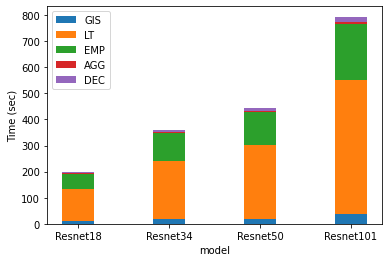

In [159]:
N = 4
width = 0.35
x = ("Resnet18", 'Resnet34', 'Resnet50', 'Resnet101')

gis = (9.264, 17.275, 20.255, 38)
lt = (124.91, 223, 280.1, 512)
emp = (58.5273, 109.137, 127.96, 217.855)
b_emp = list(np.add(gis, lt))
agg = (1.5862, 2.8231, 4.08, 7.91)
b_agg = list(np.add(b_emp, emp))
dec = (4.8266, 9, 10.5526, 18.395)
b_dec = list(np.add(b_agg, agg))

plt.bar(x, gis, width)
plt.bar(x, lt, width, bottom=gis)
plt.bar(x, emp, width, bottom=b_emp)
plt.bar(x, agg, width, bottom=b_agg)
plt.bar(x, dec, width, bottom=b_dec)

plt.ylabel('Time (sec)')
plt.xlabel('model')
plt.title('')
plt.legend(labels=['GIS', 'LT', "EMP", "AGG", "DEC"], loc=2)
# plt.show()